# Inversion Package Development
## Tyler Witt & Kieran Yanaway

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import cartopy.crs as ccrs

In [2]:
class Trajectory:
    """
    Trajectory Class
    ----------------
    A Trajectory object wraps the parameters returned by a TrajectoryEstimator object after running a trajectory inversion.
    It will also contain some functionality for visualization of the parameters, as well as statistics from the inversion.
    """

    def __init__(self, x0, y0, t0, v, theta, gamma, olat, olong, ssr=np.infty):
        """
        Initialize a Trajectory object with the inversion parameters.
        ________________________________________________________________________________________________
        x0    : float : kilometers southing  : x position of the trajectory intersection with the x-y plane
        y0    : float : kilometers easting   : y position of the trajectory intersection with the x-y plane
        t0    : float : seconds              : time of the trajectory intersection with the x-y plane
        v     : float : kilometers/second    : velocity of the meteoroid
        theta : float : radians              : elevation angle of the trajectory
        gamma : float : radians              : azimuthal angle of the trajectory (measured anticlockwise from South)
        olat  : float : degrees latitude     : latitude of the trajectory intersection with local-tangent-plane
        olong : float : degrees longitude    : longitude of the trajectory intersection with local-tangent-plane
        ssr   : float : seconds^2            : sum of squared residuals for inversion on this trajectory
        _________________________________________________________________________________________________________
        """
        self.x0 = x0
        self.y0 = y0
        self.t0 = t0
        self.v = v
        self.theta = theta
        self.gamma = gamma
        self.olat = olat
        self.olong = olong
        lat, long, h = ECEF_r_to_ECEF_g(LTP_to_ECEF_r((1000*x0,1000*y0,0),np.deg2rad(olat),np.deg2rad(olong)))
        self.lat = np.rad2deg(lat)
        self.long = np.rad2deg(long)
        self.h = h # Elevation of intersection, technically not real
        self.ssr = ssr
    
    def print_parameters(self):
        print("x0:", round(self.x0, 2), "kilometers")
        print("y0:", round(self.y0, 2), "kilometers")
        print("t0:", round(self.t0, 2), "seconds")
        print("velocity:", round(self.v, 2), "km/s")
        print("theta:", round(np.rad2deg(self.theta), 2), "degrees")
        print("gamma:", round(np.rad2deg(self.gamma), 2), "degrees")
        if self.ssr is not np.infty:
            print("sum of squared residuals:", round(self.ssr,2))

    def plot(self):
        trajlongs = np.linspace(self.long-10,self.long,2)
        slope = np.tan(self.gamma - np.pi/2)
        intercept = self.lat - slope * self.long
        ax = plt.axes(projection=ccrs.PlateCarree())
        ax.coastlines()

        minx = self.olong-5
        maxx = self.olong+5
        miny = self.olat-5
        maxy = self.olat+5
        
        ax.set_xlim((minx,maxx))
        ax.set_ylim((miny,maxy))
    
        #plt.scatter(longs,lats,label="stations",marker="v")
        plt.scatter(self.long,self.lat, c="r",label="surface intersection")
        plt.plot(trajlongs, slope * trajlongs + intercept, linestyle="--", c="k", label="trajectory")
        plt.xticks(np.linspace(minx,maxx,5))
        plt.yticks(np.linspace(miny,maxy,5))
        plt.title("Estimated Trajectory Plan View")
        plt.xlabel(r"longitude ($\degree$E)")
        plt.ylabel(r"latitude ($\degree$N)")
        plt.legend()
        plt.show()
        

In [3]:
class TrajectoryGridsearchParameters:
    """
    TrajectoryGridsearchParameters class
    ------------------------------------
    A TrajectoryGridsearchParameters class easily formats the inversion gridsearch parameters for
    interface with a TrajectoryEstimator object.
    """

    def __init__(self,x0p=(-300,300,10),y0p=(-300,300,10),t0p=(0,100,10),vep=(11.91015,81.6696,3),thp=(0,90,10),gap=(0,360,10)):
        """
        Initialize a TrajectoryGridsearchParameters object with the desired parameter ranges for a gridsearch
        __________________________________________________________________________________________
        x0p : (start, stop, n) : (kilometers, kilometers, integer) : range of x0s to search across
        y0p : (start, stop, n) : (kilometers, kilometers, integer) : range of y0s to search across
        t0p : (start, stop, n) : (kilometers, kilometers, integer) : range of t0s to search across
        vep : (start, stop, n) : (km/s, km/s, integer)             : range of velocities to search across
        thp : (start, stop, n) : (degrees, degrees, integer)       : range of thetas to search across
        gap : (start, stop, n) : (degrees, degrees, integer)       : range of gammas to search across
        _____________________________________________________________________________________________
        """
        self.x0s = None
        self.y0s = None
        self.t0s = None
        self.velocities = None
        self.thetas = None
        self.gammas = None
        
        self.set_x0p(x0p)
        self.set_y0p(y0p)
        self.set_t0p(t0p)
        self.set_vep(vep)
        self.set_thp(thp)
        self.set_gap(gap)
        
    def set_x0p(self, x0p):
        x0min = x0p[0]
        x0max = x0p[1]
        x0disc = x0p[2]
        self.x0s = np.linspace(x0min,x0max,x0disc)
        
    def set_y0p(self, y0p):
        y0min = y0p[0]
        y0max = y0p[1]
        y0disc = y0p[2]
        self.y0s = np.linspace(y0min,y0max,y0disc)

    def set_t0p(self, t0p):
        t0min = t0p[0]
        t0max = t0p[1]
        t0disc = t0p[2]
        self.t0s = np.linspace(t0min,t0max,t0disc)

    def set_vep(self, vep):
        vemin = vep[0]
        vemax = vep[1]
        vedisc = vep[2]
        self.velocities = np.linspace(vemin,vemax,vedisc)

    def set_thp(self, thp):
        thmin = thp[0]
        thmax = thp[1]
        thdisc = thp[2]
        self.thetas = np.deg2rad(np.linspace(thmin,thmax,thdisc))
        
    def set_gap(self, gap):
        gamin = gap[0]
        gamax = gap[1]
        gadisc = gap[2]
        self.gammas = np.deg2rad(np.linspace(gamin,gamax,gadisc))

&emsp; Fun idea: Instead of calculating the x and y parameters as arc lengths, ultimately resulting in a distortion of the parameters when placed on a flat, 2D plane, what if we were to project the x-y positions up onto a plane tangent to Earth's surface at the origin point, setting the elevation to the distance between the point on the sphere and its projection on the x-y plane?

In [4]:
def calc_e_Rn(lat):
    """
    Calculate the plumb line at a certain latitude, helper function for ECEF_g_to_ECEF_r() and
    ECEF_r_to_ECEF_g()
    __________________________________________________________________________
    lat : float : radians latitude : latitude at which to calculate plumb line
    __________________________________________________________________________
    
    returns : e, Rn
    __________________________________________________
    e  : float : 1      : Earth ellipsoid eccentricity
    Rn : float : meters : plumb line of Earth at latitude lat
    _________________________________________________________
    """
    a = 6378137.0 # WGS-84 Earth semimajor axis, meters
    b = 6356752.3142 # WGS-84 Earth semiminor axis, meters

    f = (a - b)/a # ellipsoid flatness
    e = np.sqrt(f*(2-f)) # eccentricity
    Rn = a / np.sqrt(1 - e * e * (np.sin(lat) ** 2)) # plumb line

    return e, Rn

def ECEF_g_to_ECEF_r(lat, long, height):
    """
    Convert a point in Earth-centered Earth-fixed geodetic coordinates (lat,long,height) to a point
    in Earth-centered Earth-fixed rectangular coordinates (x,y,z)
    """

    e,N = calc_e_Rn(lat)

    # Calc x,y,z coordinates
    x = (height + N) * np.cos(lat) * np.cos(long)
    y = (height + N) * np.cos(lat) * np.sin(long)
    z = (height + (1 - e*e) * N) * np.sin(lat)

    #print(x,y,z)
    return (x,y,z)

def ECEF_r_to_LTP(point_xyz, olat, olong):
    """
    Convert a point in Earth-centered Earth-fixed rectangular coordinates to a point relative to a local tangent plane
    
    """

    x,y,z = point_xyz # Extract coordinates from tuple
    x0,y0,z0 = ECEF_g_to_ECEF_r(olat, olong, 0) # Calculate coordinates of origin for tangent plane

    # relative point location
    xp = np.array([[x-x0],
                   [y-y0],
                   [z-z0]])
    # tangent plane 3D rotation matrix
    Rt = np.array([[-np.sin(olong),                 np.cos(olong),                0           ],
                   [-np.cos(olong) * np.sin(olat), -np.sin(olat) * np.sin(olong), np.cos(olat)],
                   [np.cos(olat) * np.cos(olong),   np.cos(olat) * np.sin(olong), np.sin(olat)]])

    x_t = Rt @ xp

    # Rotate tangent coordinates 90 degrees, +x is southing and +y is easting
    ang90 = np.pi / 2
    rot90 = np.array([[np.cos(ang90), -np.sin(ang90), 0],
                      [np.sin(ang90), np.cos(ang90),  0],
                      [0,             0,              1]])
    
    x_correct = rot90 @ x_t

    return x_correct.flatten()

def LTP_to_ECEF_r(LTP_xyz, olat, olong):
    """
    Convert a point relative to a local tangent plane to a point in Earth-centered Earth-fixed rectangular coordinates
    """
    
    x,y,z = LTP_xyz # Extract coordinates of local tangent plane point
    x0,y0,z0 = ECEF_g_to_ECEF_r(olat, olong, 0) # Calculate coordinates of origin for tangent plane

    x_correct = np.array([[x],
                          [y],
                          [z]])

    x_0 = np.array([[x0],
                    [y0],
                    [z0]])

    # Rotate point -90 degrees, to +x easting and +y northing
    angn90 = -np.pi / 2
    rotn90 = np.array([[np.cos(angn90), -np.sin(angn90), 0],
                       [np.sin(angn90), np.cos(angn90),  0],
                       [0,              0,               1]])

    x_t = rotn90 @ x_correct

    # Inverse rotation from the local tangent plane back to ECEF_r coordinates
    Rt = np.array([[-np.sin(olong),                 np.cos(olong),                0           ],
                   [-np.cos(olong) * np.sin(olat), -np.sin(olat) * np.sin(olong), np.cos(olat)],
                   [np.cos(olat) * np.cos(olong),   np.cos(olat) * np.sin(olong), np.sin(olat)]])
    xe = x_0 + Rt.T @ x_t

    return xe.flatten()

def ECEF_r_to_ECEF_g(xyz):
    """
    Convert a point in Earth-centered Earth-fixed rectangular coordinates (x,y,z) to a point
    in Earth-centered Earth-fixed geodetic coordinates (lat,long,height)
    """
    x,y,z = xyz

    long = np.arctan2(y,x)

    r = np.sqrt(x*x + y*y + z*z)
    p = np.sqrt(x*x + y*y)

    lat_prev = np.arctan2(p,z)

    loop_iterations = 6 # higher for more accurate convergence of latitude calculation (supposedly, 4 is good enough for centimeter accuracy though)
    
    for i in range(loop_iterations):
        e,Rn = calc_e_Rn(lat_prev)
        h = p / np.cos(lat_prev) - Rn
        lat_prev = np.arctan2(z, p * (1 - e*e*(Rn/(Rn+h))))
    
    h = p/np.cos(lat_prev) - calc_e_Rn(lat_prev)[1]

    return (lat_prev, long, h)
    

In [5]:
class Station:
    """
    Station Class
    -------------
    A Station object wraps the relevant data for a seismic station for ease of interfacing with a TrajectoryEstimator
    object.
    """

    def __init__(self, lat, long, elev, ta):
        """
        Initialize a Station object with the relevant positional and arrival time data.
        ______________________________________________________________________________
        lat  : float : degrees latitude  : latitudinal position of the seismic station
        long : float : degrees longitude : longitudinal position of the seismic station
        elev : float : meters            : elevation of the seismic station
        ta   : float : seconds           : arrival time of ballistic wave at seismic station
        ____________________________________________________________________________________
        """
        self.lat = lat
        self.long = long
        self.elev = elev
        self.ta = ta
        self.x = None
        self.y = None
        self.z = None

    def calc_x_y(self, olat, olong):
        """
        Calculate the x (southing) and y (easting) position of the station relative to origin latitude and longitude.
        _____________________________________________________________________________________________
        olat  : float : degrees latitude  : latitudinal position of the origin of the inversion space
        olong : float : degrees longitude : longitudinal position of the origin of the inversion space
        ______________________________________________________________________________________________
        """

        xyz = ECEF_g_to_ECEF_r(np.deg2rad(self.lat),np.deg2rad(self.long),self.elev)

        self.x, self.y, self.z = ECEF_r_to_LTP(xyz,np.deg2rad(olat),np.deg2rad(olong))
        # Convert coordinates to kilometers
        self.x /= 1000
        self.y /= 1000
        self.z /= 1000


In [6]:
class TrajectoryEstimator:
    """
    TrajectoryEstimator Class
    -------------------------
    A TrajectoryEstimator object handles inversion of the seismic data from a meteoroid's ballistic wave to estimate the
    trajectory of the meteoroid through the atmosphere.
    """

    def __init__(self, olat, olong, ot, stations=None):
        """
        Initialize a TrajectoryEstimator object with the origin latitude and longitude, as well as an array of Stations
        _____________________________________________________________________________________________
        olat     : float     : degrees latitude  : latitudinal position of the origin of the inversion space
        olong    : float     : degrees longitude : longitudinal position of the origin of the inversion space
        ot       : TIME      : seconds           : origin time of inversion space
        stations : arraylike : init_val = None   : array containing the seismic stations which will be used for the inversion
        _____________________________________________________________________________________________________________________
        """
        self.olat = olat
        self.olong = olong
        self.otime = ot
        self.stations = stations
        if stations is not None:
            for station in stations:
                station.calc_x_y(olat, olong)

    def set_stations(self, lats, longs, elevs, ts):
        """
        Set the stations array of the TrajectoryEstimator using lists containing station data
        __________________________________________________________________________________________
        lats  : arraylike : degrees latitude  : array containing latitudinal positions of stations
        longs : arraylike : degrees longitude : array containing longitudinal positions of stations
        elevs : arraylike : kilometers        : array containing elevational positions of stations
        ts    : arraylike : seconds           : array containing ballistic wave arrival times of stations
        _________________________________________________________________________________________________ 
        """
        self.stations = np.array([None] * len(lats), dtype=Station)
        for i in range(len(lats)):
            self.stations[i] = Station(lats[i], longs[i], elevs[i], ts[i])
            self.stations[i].calc_x_y(self.olat, self.olong)

    def iterative_gridsearch(self, iterations=5):

        xy_minmax = 250
        minVel = 11.91015 # km/s
        maxVel = 81.6696 # km/s
        minThe = 0 # radians
        maxThe = np.deg2rad(90) # radians
        
        c = 0.32 # velocity of sound in atmosphere (km/s)
        optimalTrajectory = Trajectory
        gammas = np.linspace(0,337.5,16)
        thetas = np.deg2rad(np.linspace(minThe,maxThe,9))
        x0s = np.linspace(-xy_minmax,xy_minmax,11)
        y0s = np.linspace(-xy_minmax,xy_minmax,11)
        velocities = np.linspace(minVel,maxVel,3)
        t0s = np.linspace(-200,200,11)
        vcons = 110/41
        initVRange = 46.789875
        p_track = 0 # percentage tracker
        
        for i in range(iterations):
            minsq = float('inf') # set initial value for least squares
            print(str(round(100 * (i/iterations), 2)) + "% complete")
            #p_track += 1/(i+1)
            
            for theta in thetas:
                
                for gamma in gammas:
                    A = np.array([[np.cos(gamma) * np.sin(theta), np.sin(gamma) * np.sin(theta), -1*np.cos(theta)],
                                  [-1*np.sin(gamma), np.cos(gamma), 0],
                                  [np.cos(gamma) * np.cos(theta), np.sin(gamma) * np.cos(theta), np.sin(theta)]]) # Rotation matrix for current parameters
                    for velocity in velocities:
                        beta = np.arcsin(c / velocity)
                        for x0 in x0s:
                            for y0 in y0s:
                                for t0 in t0s:
                                    sq_sum = 0 # sum of squares of residuals
                                    for station in self.stations:
                                        b = np.array([[station.x - x0],
                                                      [station.y - y0],
                                                      [station.z]])
                                        X, Y, Z = (A @ b).flatten() # rotated coordinate system with origin at meteoroid-surface intersection and Z along trajectory
        
                                        
                                        ti = t0 + (((np.sqrt(X*X + Y*Y) / np.tan(beta)) - Z) / velocity) # wave arrival time for current parameters
                                        sq_sum += (ti - station.ta) ** 2 # add square of residual
                                        
                                    if sq_sum < minsq:
                                        minsq = sq_sum
                                        optimalTrajectory = Trajectory(x0,y0,t0,velocity,theta,gamma,self.olat,self.olong,ssr=sq_sum) # update optimal trajectory if necessary
            
            xy_range_update = xy_minmax/(5 ** (i+1))
            if optimalTrajectory.theta < minThe:
                thetas = np.linspace(minThe, minThe + 2*np.pi / (4*(i+1)), 9)
            elif optimalTrajectory.theta > maxThe:
                thetas = np.linspace(maxThe - 2 * np.pi / (4*(i+1)), maxThe, 9)
            else:
                thetas = np.linspace(optimalTrajectory.theta - np.pi / (4*(i+1)), optimalTrajectory.theta + np.pi / (4*(i+1)), 9)
            gammas = np.mod(np.linspace(optimalTrajectory.gamma - np.pi / (2*(i+1)), optimalTrajectory.gamma + np.pi / (2*(i+1)), 17), 2*np.pi)
            x0s = np.linspace(optimalTrajectory.x0 - xy_range_update, optimalTrajectory.x0 + xy_range_update, 11)
            y0s = np.linspace(optimalTrajectory.y0 - xy_range_update, optimalTrajectory.y0 + xy_range_update, 11)
            t0s = np.linspace(optimalTrajectory.t0 - 200/(5 ** i), optimalTrajectory.t0 + 200/(5 ** i), 11)
            if optimalTrajectory.v < minVel:
                velocities = np.linspace(minVel, minVel + 2 * initVRange / (vcons ** (i+1)), 5)
            elif optimalTrajectory.v > maxVel:
                velocities = np.linspace(maxVel - 2 * initVRange / (vcons ** (i+1)), maxVel, 5)
            else:
                velocities = np.linspace(optimalTrajectory.v - initVRange / (vcons ** (i+1)), optimalTrajectory.v + initVRange / (vcons ** (i+1)), 5)
        print("100% complete")
        return optimalTrajectory
        
    def test_gridsearch(self):
        c = 0.32 # velocity of sound in atmosphere (km/s)

        minsq = float('inf') # set initial value for least squares
        optimalTrajectory = Trajectory

        p_track = 0 # percentage tracker
        theta = np.deg2rad(18.5)
        gamma = np.deg2rad(287)
        velocity = 18
        t0 = 48
        A = np.array([[np.cos(gamma) * np.sin(theta), np.sin(gamma) * np.sin(theta), -1*np.cos(theta)],
                      [-1*np.sin(gamma), np.cos(gamma), 0],
                      [np.cos(gamma) * np.cos(theta), np.sin(gamma) * np.cos(theta), np.sin(theta)]]) # Rotation matrix for current parameters

        beta = np.arcsin(c / velocity)

        nx = 151
        ny = 121
        grid = np.zeros((ny,nx))
        xind = 0
        
        for x0 in np.linspace(-200,-50,nx):
            yind = 0
            for y0 in np.linspace(180,300,ny):
                sq_sum = 0 # sum of squares of residuals
                for station in self.stations:
                    b = np.array([[station.x - x0],
                                  [station.y - y0],
                                  [station.z]])
                    X, Y, Z = (A @ b).flatten() # rotated coordinate system with origin at meteoroid-surface intersection and Z along trajectory

                    
                    ti = t0 + (((np.sqrt(X*X + Y*Y) / np.tan(beta)) - Z) / velocity) # wave arrival time for current parameters
                    sq_sum += (ti - station.ta) ** 2 # add square of residual
                grid[yind,xind] = sq_sum
                if sq_sum < minsq:
                    minsq = sq_sum
                    optimalTrajectory = Trajectory(x0,y0,t0,velocity,theta,gamma,self.olat,self.olong,ssr=sq_sum) # update optimal trajectory if necessary
                yind += 1
            xind += 1
        
        return optimalTrajectory, grid
        
    def gridsearch(self,gsp):

        c = 0.32 # velocity of sound in atmosphere (km/s)

        minsq = float('inf') # set initial value for least squares
        optimalTrajectory = Trajectory

        p_track = 0 # percentage tracker
        for theta in gsp.thetas:
            print(str(round(100 * p_track, 2)) + "% complete")
            p_track += 1/gsp.thetas.size
            for gamma in gsp.gammas:
                A = np.array([[np.cos(gamma) * np.sin(theta), np.sin(gamma) * np.sin(theta), -1*np.cos(theta)],
                              [-1*np.sin(gamma), np.cos(gamma), 0],
                              [np.cos(gamma) * np.cos(theta), np.sin(gamma) * np.cos(theta), np.sin(theta)]]) # Rotation matrix for current parameters
                for velocity in gsp.velocities:
                    beta = np.arcsin(c / velocity)
                    for x0 in gsp.x0s:
                        for y0 in gsp.y0s:
                            for t0 in gsp.t0s:
                                sq_sum = 0 # sum of squares of residuals
                                for station in self.stations:
                                    b = np.array([[station.x - x0],
                                                  [station.y - y0],
                                                  [station.z]])
                                    X, Y, Z = (A @ b).flatten() # rotated coordinate system with origin at meteoroid-surface intersection and Z along trajectory
    
                                    
                                    ti = t0 + (((np.sqrt(X*X + Y*Y) / np.tan(beta)) - Z) / velocity) # wave arrival time for current parameters
                                    sq_sum += (ti - station.ta) ** 2 # add square of residual
                                    
                                if sq_sum < minsq:
                                    minsq = sq_sum
                                    optimalTrajectory = Trajectory(x0,y0,t0,velocity,theta,gamma,self.olat,self.olong,ssr=sq_sum) # update optimal trajectory if necessary

        print("100% complete")
        return optimalTrajectory
    
    def invert_data(self, params=None, method="gridsearch"):
        optimalTrajectory = Trajectory
        
        if method == "gridsearch":
            if params is None:
                params = TrajectoryGridsearchParameters()
            optimalTrajectory = self.gridsearch(params)

        return optimalTrajectory
        

In [7]:
lats = np.array([39.387,39.473,39.355,39.632,39.118,39.466,39.374,39.237,39.618,39.403,38.952,39.486,38.984,39.616,39.848,39.086,39.256,39.130,39.396,39.061,38.857])
longs = np.array([141.57,141.29,141.20,141.30,141.26,141.00,140.94,140.91,141.08,140.77,141.22,140.79,141.04,140.90,141.24,140.72,140.63,140.66,140.63,140.59,140.72])
elevs = np.array([375,210,65,311,165,245,300,610,300,280,70,445,123,270,650,400,170,280,200,235,440])
times = np.array([180 + 42.74,240 + 7.83,240 + 13.78,240 + 22.06,240 + 28.93,240 + 37.34,240 + 38.35,240 + 41.29,240 + 43.85,240 + 57.55,240 + 59.12,300 + 1.14,300 + 1.5,300 + 3.98,300 + 6.76,300 + 7.38,300 + 8.64,300 + 9.76,300 + 12.09,300 + 20.42,300 + 39.11])

m = TrajectoryEstimator(39,141,0)
m.set_stations(lats,longs,elevs,times)

In [8]:
#traj1 = m.invert_data(TrajectoryGridsearchParameters((-95,-91,5),(205,209,5),(46,50,5),(16,20,5),(17.5,19.5,5),(286,288,5)))
#traj1 = m.invert_data(TrajectoryGridsearchParameters((-100,-80,21),(200,220,21),(40,60,21),(10,30,21),(15,25,21),(280,295,31)))
#traj1 = m.invert_data(TrajectoryGridsearchParameters((-110,-50,61),(180,250,71),(0,80,81),(11,45,35),(10,40,61),(270,300,61)))
#traj1 = m.invert_data(TrajectoryGridsearchParameters((-105,-69,13),(190,230,13),(32,62,13),(14,36,13),(17.5,21.5,13),(282,286,13)))
traj1 = m.invert_data(TrajectoryGridsearchParameters((-87,-80,11),(194,198,11),(59,63,11),(42,45,11),(19.5,20.5,11),(284,286,11)))

0% complete
9.09% complete
18.18% complete
27.27% complete
36.36% complete
45.45% complete
54.55% complete
63.64% complete
72.73% complete
81.82% complete
90.91% complete
100% complete


In [9]:
traj1.print_parameters()

x0: -84.2 kilometers
y0: 195.6 kilometers
t0: 61.0 seconds
velocity: 43.5 km/s
theta: 20.1 degrees
gamma: 285.2 degrees
sum of squared residuals: 8.3


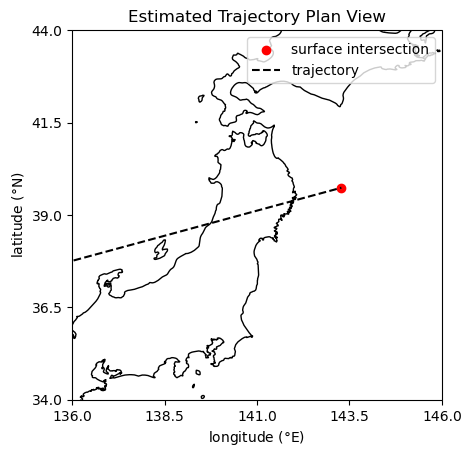

In [10]:
traj1.plot()

### Gridsearch trial: x0:(-105,-69,21), y0:(190,230,21), t0:(32,62,21), v:(14,36,21), theta:(17.5,21.5,21), gamma:(282,286,21)
x0: -83.4 kilometers <br>
y0: 196.0 kilometers <br>
t0: 62.0 seconds <br>
velocity: 36.0 km/s <br>
theta: 20.1 degrees <br>
gamma: 285.0 degrees <br>
sum of squared residuals: 11.93 <br>
~4 hours

### Gridsearch trial: x0:(-95,-75,21), y0:(190,210,21), t0:(42,72,21), v:(14,46,21), theta:(18.5,21.5,21), gamma:(283,286,21)
x0: -84.0 kilometers <br>
y0: 195.0 kilometers <br>
t0: 63.0 seconds <br>
velocity: 44.4 km/s <br>
theta: 20.0 degrees <br>
gamma: 285.25 degrees <br>
sum of squared residuals: 11.49 <br>
~4 hours

### Gridsearch trial: x0:(-90,-79,31), y0:(190,205,31), t0:(55,72,21), v:(30,46,21), theta:(19.5,21.5,31), gamma:(283,286,21)
x0: -83.77 kilometers <br>
y0: 196.0 kilometers <br>
t0: 61.8 seconds <br>
velocity: 43.6 km/s <br>
theta: 20.03 degrees <br>
gamma: 285.1 degrees <br>
sum of squared residuals: 11.34 <br>
~12 hours

At this point, the station x-y calculation was updated, leading to an apparently improved performance, with more accurate positioning of stations in the inversion local-tangent-plane coordinate system.

### Gridsearch trial: x0:(-87,-80,11), y0:(194,198,11), t0:(59,63,11), v:(42,45,11), theta:(19.5,20.5,11), gamma:(284,286,11)
x0: -84.2 kilometers<br>
y0: 195.6 kilometers<br>
t0: 61.0 seconds<br>
velocity: 43.5 km/s<br>
theta: 20.1 degrees<br>
gamma: 285.2 degrees<br>
sum of squared residuals: 8.3<br>
~5 minutes

In [11]:
traj, grid = m.test_gridsearch()

In [12]:
minloc = np.unravel_index(np.argmin(grid), grid.shape)
yloc, xloc = minloc

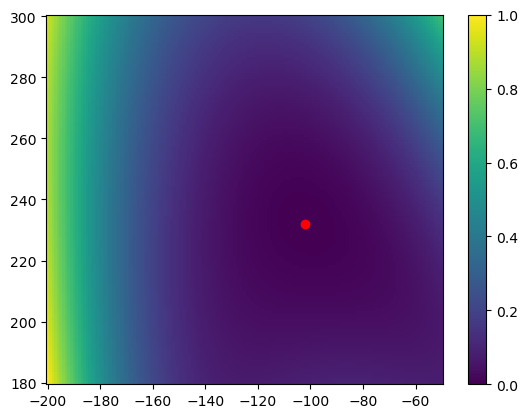

In [13]:
nx = 151
ny = 121

x = np.linspace(-200,-50,nx)
y = np.linspace(180,300,ny)
plt.pcolormesh(x,y,grid)
plt.scatter(x[xloc],y[yloc], c="r")
plt.colorbar()

In [14]:
grid.min()

190.03723694889266

In [18]:
tolat = 1
tolong = 130

teststat = Station(3,132,10,8)
teststat.calc_x_y(tolat,tolong)

lat,long,h = ECEF_r_to_ECEF_g(LTP_to_ECEF_r((1000*teststat.x,1000*teststat.y,1000*teststat.z),np.deg2rad(tolat),np.deg2rad(tolong)))

print(np.rad2deg(lat),np.rad2deg(long),h)

3.0000000000000004 132.0 10.0


[1] M. S. Grewal, Global navigation satellite systems, inertial navigation, and integration. 2020.
‌